# Benchmark for pgm reader functions

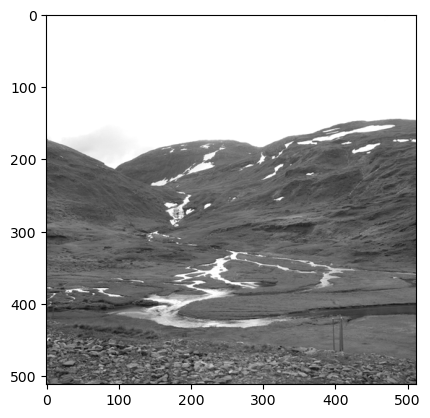

In [5]:
from matplotlib.pyplot import imshow
import numpy as np

def read_pgm(file_name):
    with open(file_name, 'rb') as f:
        # Read the header
        f.readline()  # P5
        dimensions = f.readline().split()
        width, height = int(dimensions[0]), int(dimensions[1])
        max_val = int(f.readline())
        
        # Read the image data
        img = []
        for _ in range(height):
            row = []
            for _ in range(width):
                pixel = ord(f.read(1))
                row.append(pixel)
            img.append(row)
    return img

X = read_pgm("../JIN_SRNet/BossBase-1.01-precover/1.pgm")
imshow(X,cmap="gray")

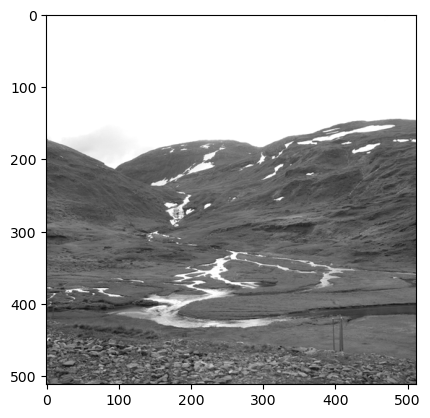

In [6]:
def read_pgm_with_numpy(file_name):
    with open(file_name, 'rb') as f:
        # Skip header
        f.readline()
        dimensions = f.readline().split()
        width, height = int(dimensions[0]), int(dimensions[1])
        max_val = int(f.readline())

        # Read the image data
        img = np.fromfile(f, dtype=np.uint8, count=width * height).reshape((height, width))
    return img

X = read_pgm_with_numpy("../JIN_SRNet/BossBase-1.01-precover/1.pgm")
imshow(X,cmap="gray")

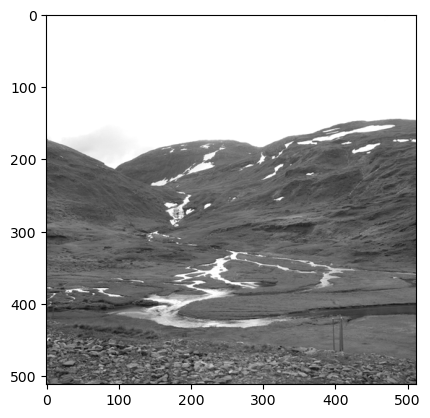

In [7]:
from PIL import Image

def read_pgm_with_pil(file_name):
    with Image.open(file_name) as img:
        return np.array(img)

X = read_pgm_with_pil("../JIN_SRNet/BossBase-1.01-precover/1.pgm")
imshow(X,cmap="gray")

In [8]:
%timeit read_pgm("../JIN_SRNet/BossBase-1.01-precover/1.pgm")

22.8 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit read_pgm_with_numpy("../JIN_SRNet/BossBase-1.01-precover/1.pgm")

48.8 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%timeit read_pgm_with_pil("../JIN_SRNet/BossBase-1.01-precover/1.pgm")

152 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Conclusion
read_pgm_numpy is the most efficient way to read pgm files

# Processing pgm files

In [11]:
from torchvision import transforms
from PIL import Image
import matplotlib.pylab
import torch

In [12]:
precover = read_pgm_with_numpy("../JIN_SRNet/BossBase-1.01-precover/1.pgm")
precover.shape

(512, 512)

### Checking the type of data used in the training of ImageCompressor

0
255
uint8


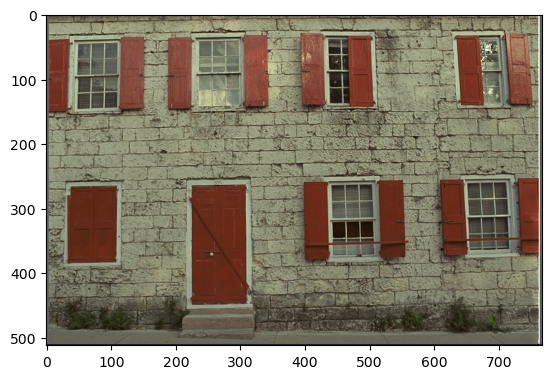

In [13]:
img = Image.open("../data1/liujiaheng/data/kodak/kodim01.png").convert("RGB")
np_img = np.array(img)
print(np.min(np_img))
print(np.max(np_img))
print(np_img.dtype)
imshow(np_img)

$\boxed{\Rightarrow\ we\ know\ that\ images\ used\ in\ the\ training\ of\ ImageCompressor\ are\ uint8\ between\ 0\ and\ 255.}$

### Converting  grayscale images to RGB tensors

In [14]:
transform = transforms.ToTensor()
# Transform the np array to pytorch tensor
# Duplicate the channel 3 times (JIN is trained on RGB images and same for ImageCompressor so we convert gray scale images to RGB by duplicating the gray channel)
precover_tensor = transform(precover).repeat(1,3,1,1)
precover_tensor.shape

torch.Size([1, 3, 512, 512])

### Reconstructing the image from the tensor

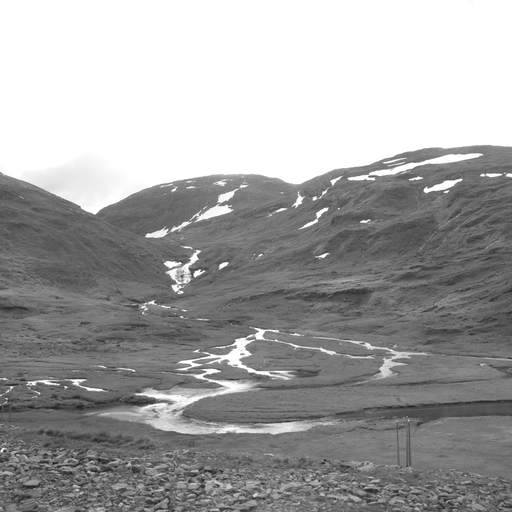

In [17]:
to_pil = transforms.ToPILImage()
precover_img = to_pil(precover_tensor[0])
precover_img

### Applying the ImageCompressor model to the image

In [21]:
import sys
sys.path.append("../iclr_17_compression/")

mse_loss: 0.0007308362401090562
bpp: 0.3296113610267639


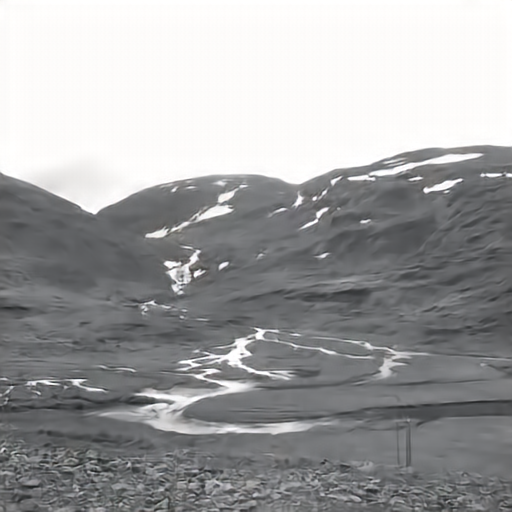

In [26]:
from model import ImageCompressor, load_model

with torch.no_grad():
    model_path = "../iclr_17_compression/checkpoints/baseline/iter_1590000.pth.tar"
    model = ImageCompressor()
    load_model(model,model_path)
    net = model.cuda()
    net.eval()
    cover, mse_loss, bpp = net(precover_tensor.cuda())

print(f"mse_loss: {mse_loss.cpu().item()}")
print(f"bpp: {bpp.cpu().item()}")
cover = to_pil(cover[0])
cover

### Difference precover/cover

In [31]:
import matplotlib.pyplot as plt

In [161]:
precover_np = np.array(precover_img)
cover_np    = np.array(cover)
# converting uint8 to int. Otherwise, when the difference is negative we have zero (becaus uint8 can't be negative) 
diff = np.abs(precover_np.astype(int) - cover_np.astype(int))  
print(diff)

[[[10 11 13]
  [ 7  8 10]
  [ 7  8 10]
  ...
  [ 0  1  1]
  [ 0  2  4]
  [ 4  6 10]]

 [[ 5  6 10]
  [ 5  7  9]
  [ 4  7  9]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 5  5  8]
  [ 4  5  7]
  [ 4  5  7]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  0  2]
  [12 12 11]
  [13 12 13]
  ...
  [ 4  6  3]
  [12 12  9]
  [23 22 18]]

 [[19 20 22]
  [ 2  2  1]
  [ 3  3  5]
  ...
  [ 0  3  0]
  [ 2  4  1]
  [14 15 12]]

 [[25 23 21]
  [23 22 21]
  [13 12 11]
  ...
  [16 20 16]
  [22 25 22]
  [ 2  0  2]]]


In [159]:
print("min diff: ", np.min(diff))
print("max diff: ", np.max(diff))

min diff:  0
max diff:  92


In [153]:
diff.dtype

dtype('int64')

#### Plotting the difference

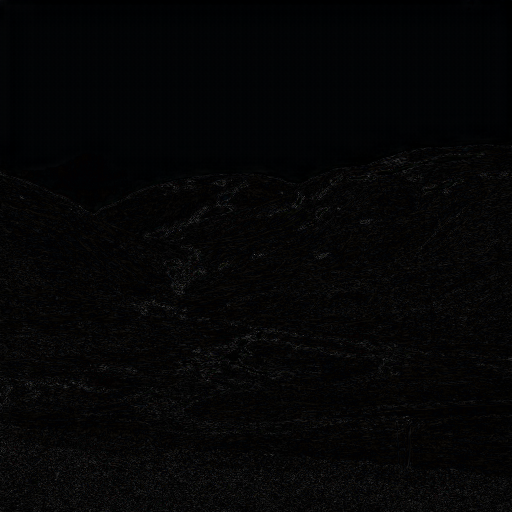

In [152]:
Image.fromarray(diff.astype("uint8"))

There are few differences between the precover and the cover.

#### Statistcis on the difference

In [154]:
# Moving the axis so we can have the RGB channels in axis 0 (easier computation for )
diff_CHW = np.moveaxis(diff[:,:,:],[0, 1, 2], [1, 2, 0]) # CHW -> channel, height, width

diff_mean_RGB = np.mean((np.mean(diff_CHW,axis=1)),axis=1)
print("avg diff R:   ",diff_mean_RGB[0])
print("avg diff G:   ",diff_mean_RGB[1])
print("avg diff B:   ",diff_mean_RGB[2])
print("avg diff RGB: ",np.mean(diff))

avg diff R:    4.6306915283203125
avg diff G:    4.867565155029297
avg diff B:    5.242134094238281
avg diff RGB:  4.913463592529297


The average absolute difference is pretty low, which confirms what we saw when we plotted the image.

In [155]:
diff_std = [np.std(diff_CHW[0]), np.std(diff_CHW[1]),np.std(diff_CHW[2])]

print("std diff R:   ", diff_std[0])
print("std diff G:   ", diff_std[1])
print("std diff B:   ", diff_std[2])
print("std diff RGB: ",np.std(diff))

std diff R:    5.181035992716489
std diff G:    4.889491236881272
std diff B:    4.754661593785937
std diff RGB:  4.951335051961276
